# Flux discretizations

We showcase the different alternatives for the discretization of fluxes in PorePy. To this aim, we focus on single-phase flow in unfractured domains. <br>
We consider three discretization schemes:
* two-point flux approximation
* multi-point flux approximation
* dual virtual element method

Mixed finite elements of the lowest order, a.k.a RT0-P0, are supported in PorePy, but not demonstrated herein. While this tutorial considers a 2d domain, most of the code works for 1d, 2d, and 3d domains. The case of mixed-dimensional domains containing both fractures and a porous medium is covered in the [single phase flow](./single_phase_flow.ipynb) tutorial. 

## Problem statement

Let $\Omega$ be a regular domain with boundary $\partial \Omega$. The boundary can be divided in two non-overlapping parts on which we will impose Dirichlet ($\partial \Omega_d$) and Neumann ($\partial \Omega_n$) boundary conditions, respectively. We indicate with $\mathbf{n}$ the outward unit normal vector of $\partial \Omega$.<br>
The single-phase flow can be written in
* using two primary variables:
$$\nabla \cdot \mathbf{u} = f \qquad \mathbf{u} = - K \nabla p$$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \qquad \mathbf{u} \cdot \mathbf{n} = u_b$$
* or with a single primary variable:
$$ - \nabla \cdot K \nabla p = f $$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \qquad - K \nabla p \cdot \mathbf{n} = u_b$$

Here, $f$ is a scalar source/sink term, $K$ is the permeability matrix, $p_b$ is the pressure at the boundary (Dirichlet condition), and $u_b$ is the flux at the boundary (Neumann condition).<br>

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem. <br><br>

For the example we assume: $\Omega$ as presented below, $\partial \Omega_d = \partial \Omega$, $\partial \Omega_n = \emptyset$, with data: $f = 1$, $K = I$ and $p_b = 0$.

## Import basic modules

Before creating the grid we import NumPy, the SciPy sparse library and PorePy.

In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp

## Creation of the grid

We specify the number of cells in each dimension and the physical size of the domain. Then we create a Cartesian grid and compute geometric properties such as face centers, cell volumes etc.

In [2]:
Nx = Ny = 20
phys_dims = [1, 1]
g = pp.CartGrid([Nx, Ny], phys_dims)
g.compute_geometry()

We plot the grid using the interface with matplotlib.

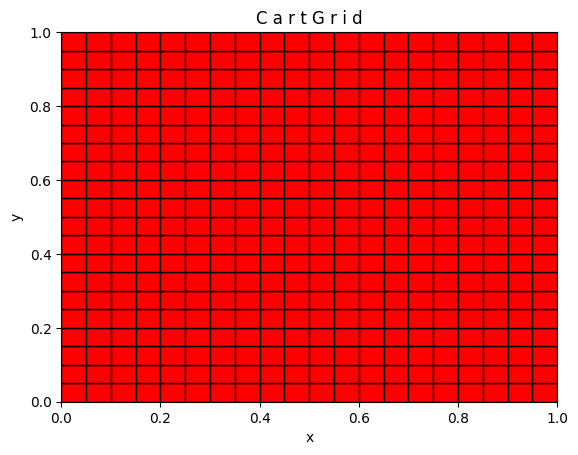

In [3]:
pp.plot_grid(g, plot_2d=True)

# Define the problem data

We declare the permeability matrix $K$, the scalar source term $f$, and the boundary conditions

In [4]:
# Permeability
perm = pp.SecondOrderTensor(np.ones(g.num_cells))

# Unitary scalar source already integrated in each cell
f = g.cell_volumes

# Boundary conditions
b_faces = g.tags["domain_boundary_faces"].nonzero()[0]
bc = pp.BoundaryCondition(g, b_faces, ["dir"] * b_faces.size)
bc_val = np.zeros(g.num_faces)

# Collect all parameters in a dictionary
parameters = {"second_order_tensor": perm, "source": f, "bc": bc, "bc_values": bc_val}

Once all the data are created we group them in a dictionary, where the keyword `"flow"` represent the physical process considered and ensures that the discretization objects use the correct parameters. Note that the call to `initialize_default_data` assigns default values to the flow parameters which are not specified. This means that we could have omitted the specification of `"bc_values"` and `"second_order_tensor"`, since we have assigned the default values for these.

In [5]:
data_key = "flow"
data = pp.initialize_default_data(g, {}, data_key, parameters)

## Problem solution

In this section we present all the approaches to solve the problem.

### Two-point flux approximation

The two-point flux approximation solves the single-phase flow problem using pressure as the primary variable. We use this to discretize the flux term, before assembling it. The source term is passed directly without any need for discretization. The ensuing system of linear equations is solved for pressures using a direct sparse solver.

In [6]:
flow_discretization = pp.Tpfa(data_key)
flow_discretization.discretize(g, data)
A, b_flow = flow_discretization.assemble_matrix_rhs(g, data)

b_rhs = data[pp.PARAMETERS]["flow"]["source"]

p_tpfa = sps.linalg.spsolve(A, b_flow + b_rhs)

We visualize the solution using the plot grid function:

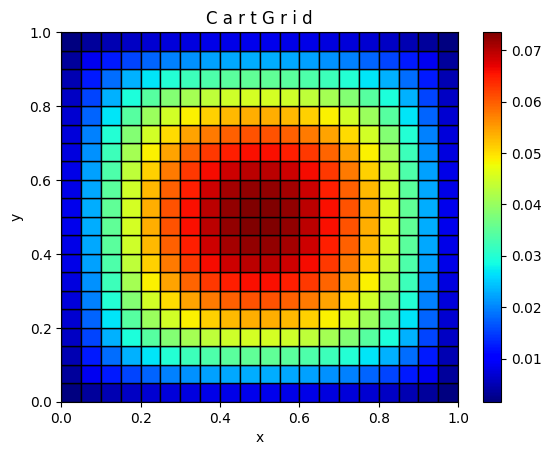

In [7]:
pp.plot_grid(g, p_tpfa, plot_2d=True)

Consistency check (included to detect if this tutorial is broken):

In [8]:
assert np.isclose(np.sum(p_tpfa), 14.192684340967551)

### Multi-point flux approximation 

The multi-point flux approximation also uses pressure as the only primary variable. We discretize the flux term anew with the MPFA, and assemble the matrix. Note that the call to Mpfa.discretize() will override the already stored discretization matrix for Tpfa. We reuse the source term discretization, as this is the same for TPFA and MPFA.

In [9]:
flow_discretization = pp.Mpfa(data_key)
flow_discretization.discretize(g, data)
A, b_flow = flow_discretization.assemble_matrix_rhs(g, data)

p_mpfa = sps.linalg.spsolve(A, b_flow + b_rhs)

To represent the solution:

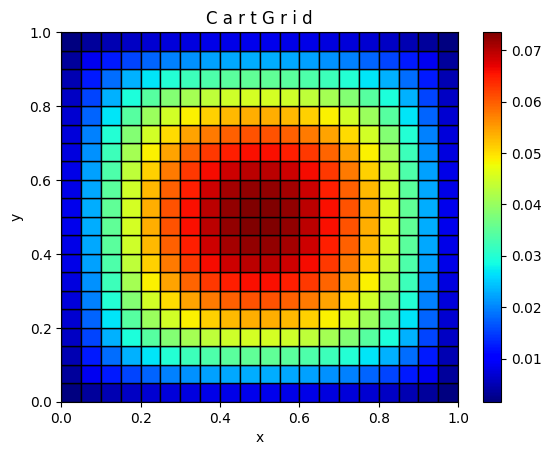

In [10]:
pp.plot_grid(g, p_mpfa, plot_2d=True)

Consistency check:

In [11]:
assert np.isclose(np.sum(p_mpfa), 14.192684340967542)

### Dual virtual element method

The dual virtual element method solves the single-phase flow problem using both pressures and fluxes as primary variables.

In [12]:
flow_discretization = pp.MVEM("flow")
flow_discretization.discretize(g, data)
A, b_flow = flow_discretization.assemble_matrix_rhs(g, data)

rhs_discretization = pp.DualScalarSource("flow")

data[pp.PARAMETERS]["flow"]["source"] = data[pp.PARAMETERS]["flow"]["source"]
rhs_discretization.discretize(g, data)
_, b_rhs = rhs_discretization.assemble_matrix_rhs(g, data)

up = sps.linalg.spsolve(A, b_flow + b_rhs)

# Extract the normal flux and pressure from the solution
u_mvem = flow_discretization.extract_flux(g, up, data)
p_mvem = flow_discretization.extract_pressure(g, up, data)

# For visualisation purpose project the flux on a vector piecewise constant field
P0u = flow_discretization.project_flux(g, u_mvem, data)

To represent the pressure and velocity solution:

/home/yzabegaev/workspace/porepy/src/porepy/viz/plot_grid.py:198: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim3d(z)


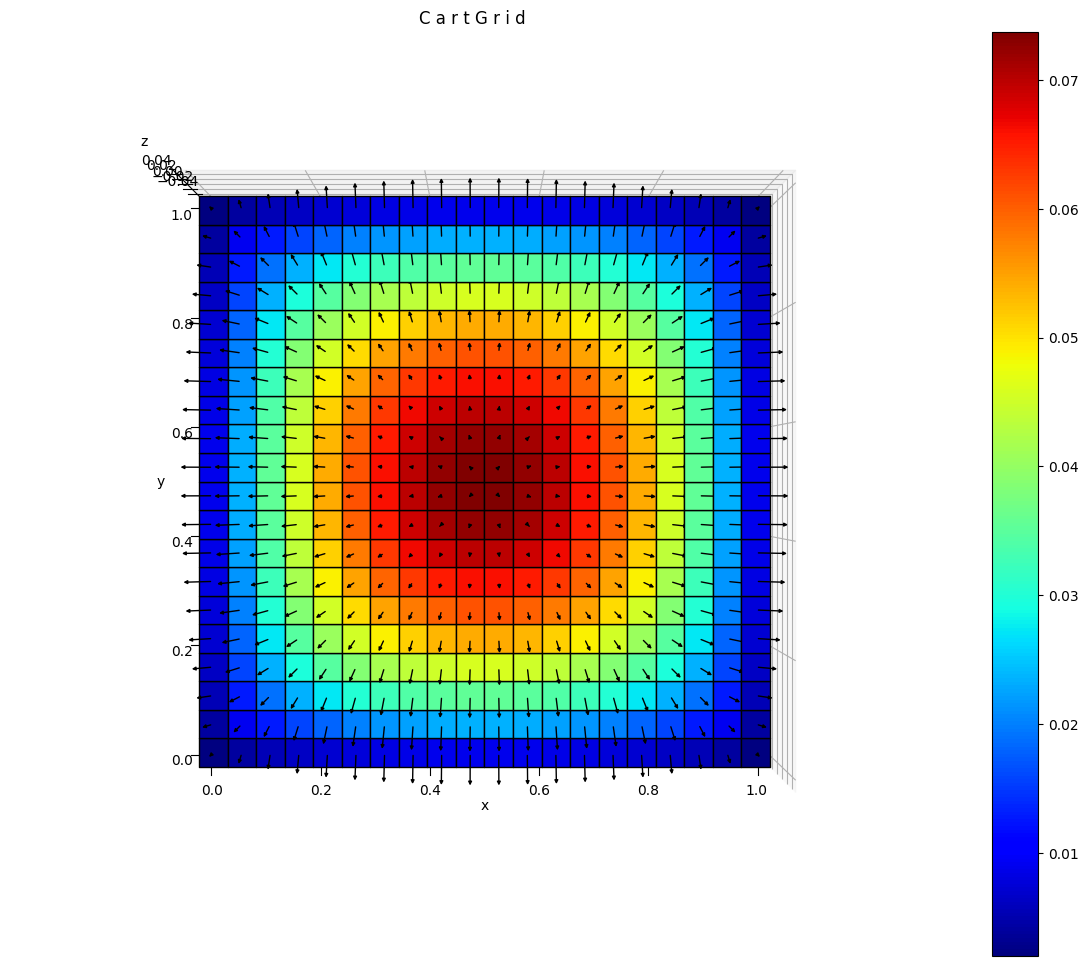

In [13]:
pp.plot_grid(g, p_mvem, P0u * 0.2, figsize=(15, 12))

Consistency check:

In [14]:
assert np.isclose(np.sum(p_mvem), 14.348068220560325)
assert np.isclose(np.sum(u_mvem), 0)
assert np.isclose(np.sum(P0u), 0)

# What we have explored
Elliptic equations (e.g., diffusion) in PorePy are specified in terms of a mesh, a second order diffusion tensor, source terms and boundary conditions, all of which must be assigned with a specific syntax. To discretize the equations, PorePy provides two- and multi-point finite volume discretizations as well as the lowest order mixed virtual element method. Discrete solutions are obtained by first discretizing, then assembling and solving the equations.